<a href="https://colab.research.google.com/github/ife-dolapo/Data-Analytics-and-Artificial-Intelligence-Project/blob/main/Project_2_Data_Cleaning_and_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
stock_pricesdf=pd.read_csv('historical_stock_prices.csv')
print(stock_pricesdf.head())

# Load second dataset
stocksdf=pd.read_csv('historical_stocks.csv')
print(stocksdf.head())

# Convert 'date' to datetime datatype
stock_pricesdf['date']=pd.to_datetime(stock_pricesdf['date'])

# Drop bad rows in the date column
stock_pricesdf=stock_pricesdf.dropna(subset=['date'])

# Merge the two dataframes
merge_df=pd.merge(stock_pricesdf,stocksdf,on='ticker')

# Display merged dataframe
print("\nThe first few rows of the merged dataframe:")
print(merge_df.head())

  ticker   open  close  adj_close    low   high   volume        date
0    AHH  11.50  11.58   8.493155  11.25  11.68  4633900  2013-05-08
1    AHH  11.66  11.55   8.471151  11.50  11.66   275800  2013-05-09
2    AHH  11.55  11.60   8.507822  11.50  11.60   277100  2013-05-10
3    AHH  11.63  11.65   8.544494  11.55  11.65   147400  2013-05-13
4    AHH  11.60  11.53   8.456484  11.50  11.60   184100  2013-05-14
  ticker exchange                                    name             sector  \
0    PIH   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
1  PIHPP   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
2   TURN   NASDAQ                180 DEGREE CAPITAL CORP.            FINANCE   
3   FLWS   NASDAQ                 1-800 FLOWERS.COM, INC.  CONSUMER SERVICES   
4   FCCY   NASDAQ           1ST CONSTITUTION BANCORP (NJ)            FINANCE   

                     industry  
0  PROPERTY-CASUALTY INSURERS  
1  PROPERTY-CASUALTY INSURERS  
2  FINANC

In [ ]:
# Task 1: Advanced Data Cleaning

# Check for missing values in the merged dataframe
print("Missing values in the merged dataframe:")
missing_values=merge_df.isnull().sum()
print(missing_values)

# Handle missing values in the categorical columns
categorical_columns = merge_df.select_dtypes(include=['object']).columns
merge_df[categorical_columns] = merge_df[categorical_columns].fillna('Unknown')

# Display missing values after filling the columns
print("\nMissing values after filling:")
print(merge_df.isnull().sum())



Missing values in the merged dataframe:
ticker            0
open              0
close             0
adj_close         0
low               0
high              0
volume            0
date              0
exchange          0
name              0
sector       133862
industry     133862
dtype: int64

Missing values after filling:
ticker       0
open         0
close        0
adj_close    0
low          0
high         0
volume       0
date         0
exchange     0
name         0
sector       0
industry     0
dtype: int64


### Task 1 Contd: Outlier Detection and Handling (IQR Method)

This step identifies and removes outliers from key numeric columns using the Interquartile Range (IQR) method.

- **Outlier Detection**:  
  A custom function `detect_outliers_iqr()` was defined to flag values outside the range:  
  \[Q1 - 1.5 × IQR, Q3 + 1.5 × IQR\]  
  Applied to the `close` and `volume` columns to quantify extreme values.

- **Outlier Removal**:  
  A second function `remove_outliers_iqr()` was used to filter out rows with outliers in:
  - `close` (first pass)
  - `volume` (second pass, applied to already filtered data)

- **Results**:  
  - The shape of the dataset was logged before and after each removal step.
  - The final cleaned dataset (`cleaned_merge_df`) excludes extreme values in both `close` and `volume`, improving data quality for downstream analysis.

This ensures that statistical distortions caused by outliers are minimized, leading to more robust feature engineering and modeling.

In [ ]:
# Task 1 Contd: Outlier Detection and Handling
# Define a function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)]

# Daisplay shape of merged dataframe before removing outliers
print("Shape of the merged dataframe before removing outliers:")
print(merge_df.shape)

# Applying the function on the 'close' and 'volumne' columns
outliers_close = detect_outliers_iqr(merge_df, 'close')
outliers_volume = detect_outliers_iqr(merge_df, 'volume')

# Display the lenght of the detected outliers
print("\nNumber of detected outliers in 'close' column:", len(outliers_close))

print("\nNumber of detected outliers in 'volume' column:", len(outliers_volume))

# Handle outliers in Volume and Close columns
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Apply to both columns
# First removal: remove outliers from 'close'
first_removal = remove_outliers_iqr(merge_df, 'close')

# Second removal: remove outliers from 'volume' in the already filtered data
second_removal = remove_outliers_iqr(first_removal, 'volume')

# Final cleaned dataset after removing outliers from 'close' and 'volume'
cleaned_merge_df = second_removal

# Display the shape of the dataset after removal
print("After removing 'close' outliers:", first_removal.shape)
print("After removing 'volume' outliers:", second_removal.shape)
print("Final cleaned dataset shape:", cleaned_merge_df.shape)


Shape of the merged dataframe before removing outliers:
(1048575, 12)

Number of detected outliers in 'close' column: 87404

Number of detected outliers in 'volume' column: 148073
After removing 'close' outliers: (961171, 12)
After removing 'volume' outliers: (822964, 12)
Final cleaned dataset shape: (822964, 12)


**Error Identification and Correction**

This cell performs essential data cleaning steps to ensure the integrity of financial time series data:

*   Removes duplicate rows to prevent redundancy.
*   Sets the  column as the index to enable time-based interpolation.
*   Identifies and replaces negative values in financial columns (*open*, *close*, *high*, *low*, *volume*) with , since these values are invalid in this context.
*   Interpolates missing values using time-aware interpolation to preserve chronological trends.
*   Prints a summary of any remaining missing values after correction.

In [ ]:
# Task 1 Contd: Error Identification and Correction

#Make a copy of the dataframe
cleaned_merge_df = merge_df.copy()

# Remove duplicates
print("Number of duplicate rows before removal:", cleaned_merge_df.duplicated().sum())
cleaned_merge_df.drop_duplicates(inplace=True)

# Ensure Date column is set as index for time-based interpolation
cleaned_merge_df.set_index('date', inplace=True)

# Columns that should never be negative
financial_cols = ['open', 'close', 'high', 'low', 'volume']

# Check for negative values in non-negative columns
# Step 1: Replace negative values with NaN
for col in financial_cols:
    if (cleaned_merge_df[col] < 0).any():
        print(f"Negative values found in {col}, replacing with NaN...")
        cleaned_merge_df[col] = cleaned_merge_df[col].apply(lambda x: np.nan if x < 0 else x)

# Step 2: Interpolate missing values (including those replaced above)
cleaned_merge_df.loc[:, financial_cols] = cleaned_merge_df[financial_cols].interpolate(method='time')

# Final check
print("Remaining missing values:\n", cleaned_merge_df[financial_cols].isnull().sum())



Number of duplicate rows before removal: 0
Remaining missing values:
 open      0
close     0
high      0
low       0
volume    0
dtype: int64


**Task 2: Data Transformation and Feature Engineering**

This cell prepares the cleaned dataset for modeling by applying key transformation steps:

**Feature Engineering**
*   Rolling Averages: Adds 7-day and 30-day moving averages of the  price to capture short- and long-term trends.
*   Volatility: Computes 7-day rolling standard deviation of *close* to measure price fluctuations.
*   RSI (Relative Strength Index): Calculates a 14-day RSI to identify overbought or oversold conditions based on price momentum.

Data Normalization
*   StandardScaler is applied to all numeric columns to ensure features have mean 0 and standard deviation 1.
*   This helps models converge faster and prevents features with large scales from dominating.

**Encoding Categorical Variables**
*   One-hot encoding is applied to all object-type columns to convert categorical data into numeric format.
* *drop_first=True* avoids multicollinearity by removing the first category in each encoded column.

In [34]:
# Task 2: Data Transformation
# Feature Engineering

# Rolling Averages & Volatility
# 7-day and 30-day rolling averages for 'Close'
cleaned_merge_df['close_7d_avg'] = cleaned_merge_df['close'].rolling(window=7).mean()
cleaned_merge_df['close_30d_avg'] = cleaned_merge_df['close'].rolling(window=30).mean()

# 7-day rolling standard deviation (volatility)
cleaned_merge_df['close_7d_volatility'] = cleaned_merge_df['close'].rolling(window=7).std()


In [36]:
# Task 2 Contd: Technical Indicators (Simple Examples)
# Relative Strength Index (RSI) Calculation

delta = cleaned_merge_df['close'].diff() # Calculates the day to day change in 'close' price
gain = delta.clip(lower=0) # Keeps only positive changes (gains), sets negatives to 0.
loss = -delta.clip(upper=0) # Keeps only negative changes (losses), sets positives to 0 and flips sign

# Compute 14-day rolling averages of gains and losses.
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Calculate the relative strength (RS) as the ratio of average gain to average loss.
rs = avg_gain / avg_loss

# Convert RS into the RSI scale (0–100). RSI helps identify overbought or oversold conditions.
cleaned_merge_df['RSI_14'] = 100 - (100 / (1 + rs))

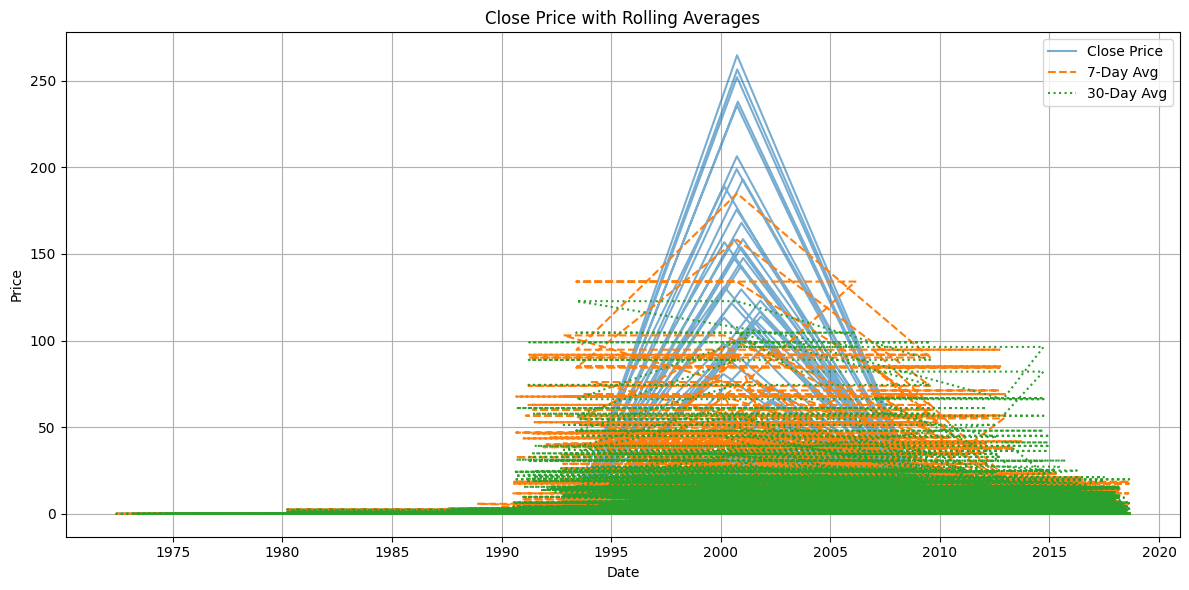

In [50]:
# Visualization
# Line Plot: close vs. Rolling Averages
# This visualization shows how close_7d_avg and close_30d_avg smooth the price trend
plt.figure(figsize=(12, 6))
plt.plot(cleaned_merge_df['close'], label='Close Price', alpha=0.6)
plt.plot(cleaned_merge_df['close_7d_avg'], label='7-Day Avg', linestyle='--')
plt.plot(cleaned_merge_df['close_30d_avg'], label='30-Day Avg', linestyle=':')
plt.title('Close Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Task 2 Contd: Data Normalization / Standardization
from sklearn.preprocessing import StandardScaler

# Selecting numeric columns to scale
numeric_cols = cleaned_merge_df.select_dtypes(include='number').columns

# Applying standardization
scaler = StandardScaler()
cleaned_merge_df[numeric_cols] = scaler.fit_transform(cleaned_merge_df[numeric_cols])

In [38]:
# Encoding Categorical Variables
# One-hot encode categorical columns
categorical_cols = cleaned_merge_df.select_dtypes(include='object').columns
cleaned_merge_df = pd.get_dummies(cleaned_merge_df, columns=categorical_cols, drop_first=True)

In [40]:
# Confirming all transformations
print(cleaned_merge_df.info())
print(cleaned_merge_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048575 entries, 2013-05-08 to 2013-08-13
Columns: 695 entries, open to industry_Unknown
dtypes: bool(685), float64(10)
memory usage: 773.0 MB
None
                open     close  adj_close       low      high    volume  \
date                                                                      
1994-04-12 -0.007602 -0.007448  -0.005949 -0.007416 -0.007771 -0.154147   
1984-08-09 -0.020646 -0.019910  -0.018432 -0.020909 -0.019708 -0.154774   
2002-10-08 -0.017162 -0.016913  -0.015414 -0.017889 -0.016477 -0.046740   
1997-10-06 -0.016565 -0.016052  -0.014637 -0.016676 -0.015978 -0.155852   
2013-08-13 -0.019334 -0.018633  -0.017135 -0.019552 -0.018482 -0.155852   

            close_7d_avg  close_30d_avg  close_7d_volatility    RSI_14  ...  \
date                                                                    ...   
1994-04-12     -0.025706      -0.039511            -0.025053 -0.884085  ...   
1984-08-09     -0.027477      -0.041

In [41]:
# Confirming there are no missing values before splitting
print(cleaned_merge_df.isnull().sum())

open                                     0
close                                    0
adj_close                                0
low                                      0
high                                     0
                                        ..
industry_TELECOMMUNICATIONS EQUIPMENT    0
industry_TELEVISION SERVICES             0
industry_TEXTILES                        0
industry_TRANSPORTATION SERVICES         0
industry_Unknown                         0
Length: 695, dtype: int64


### Feature Pruning — Removal of Redundant Columns

After one-hot encoding categorical variables such as `ticker`, `sector`, `industry`, and `exchange`, the dataset expanded to over 600 columns. While these encodings provide useful categorical context, they significantly increase dimensionality and risk overfitting.

To improve model interpretability and performance, I performed feature pruning by:

- Dropping all one-hot encoded columns except a select few (e.g., `sector_*`, `exchange_*`) that provide macro-level insights.
- Retaining only core numeric features and engineered signals such as:
  - Price-based features (`open`, `close`, `adj_close`, `high`, `low`, `volume`)
  - Rolling statistics (`close_7d_avg`, `close_30d_avg`, `close_7d_volatility`)
  - Momentum indicator (`RSI_14`)
  - Selected categorical indicators (`sector_*`, `exchange_*`)

This reduced the feature set from **695 columns to 23**, streamlining the dataset for modeling while preserving predictive power.

In [45]:
# Drop all one-hot encoded ticker columns
ticker_cols = [col for col in cleaned_merge_df.columns if col.startswith('ticker_')]
cleaned_merge_df.drop(columns=ticker_cols, inplace=True)

print(f"Dropped {len(ticker_cols)} ticker columns. Remaining columns: {cleaned_merge_df.shape[1]}")

Dropped 300 ticker columns. Remaining columns: 395


In [47]:
# Drop all one-hot encoded industry and name columns
industry_cols = [col for col in cleaned_merge_df.columns if col.startswith('industry_')]
name_cols = [col for col in cleaned_merge_df.columns if col.startswith('name_')]

cleaned_merge_df.drop(columns=industry_cols + name_cols, inplace=True)

print(f"Dropped {len(industry_cols) + len(name_cols)} columns. Remaining: {cleaned_merge_df.shape[1]}")

Dropped 372 columns. Remaining: 23


### Task 4: Target Creation and Feature/Target Separation

In this step, I defined the prediction target and prepare the dataset for modeling.

- **Target Definition**: I created a new column `target_return`, which represents the percentage change in closing price from the current day to the next. This is calculated using `.pct_change().shift(-1)` to align the target with the current day's features.
- **Missing Value Handling**: Rows with `NaN` in the target column are dropped. These typically occur at the end of the dataset due to the `.shift(-1)` operation.
- **Feature/Target Separation**:  
  - `X`: Contains all features except the target  
  - `y`: Contains only the `target_return` column

This prepares the dataset for train/validation/test splitting and ensures the target is properly aligned for supervised learning.

In [51]:
# Task 4:
from sklearn.model_selection import train_test_split

# Step 1: Define target as next-day return
cleaned_merge_df['target_return'] = cleaned_merge_df['close'].pct_change().shift(-1)

# Step 2: Drop rows with NaN in target (usually last row)
cleaned_merge_df.dropna(subset=['target_return'], inplace=True)

# Step 3: Define features and target
X = cleaned_merge_df.drop(columns=['target_return'])
y = cleaned_merge_df['target_return']

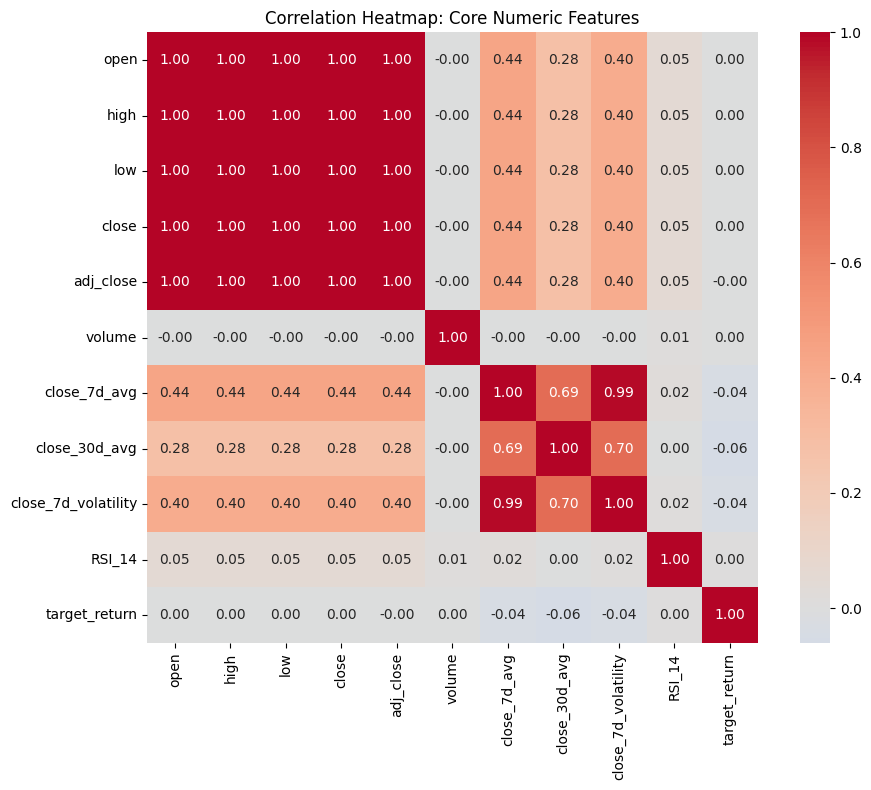

In [54]:
# Correlation HeatMap
# To show relationships between features and the target.
# Select core numeric features for analysis and visualization
core_features = [
    'open', 'high', 'low', 'close', 'adj_close', 'volume',
    'close_7d_avg', 'close_30d_avg', 'close_7d_volatility', 'RSI_14', 'target_return'
]

# Filtering the DataFrame to include only the core features
viz_df = cleaned_merge_df[core_features]

# Compute correlation matrix
corr = viz_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True)
plt.title('Correlation Heatmap: Core Numeric Features')
plt.tight_layout()
plt.show()

### Task 4 contd: Train/Validation/Test Split and Export

This step finalizes the data preparation by splitting the cleaned dataset into three subsets:
- **Training set (70%)**: Used to fit the model
- **Validation set (15%)**: Used to tune hyperparameters and prevent overfitting
- **Test set (15%)**: Used to evaluate final model performance

All splits are saved as CSV files for future use in modeling workflows.

In [55]:
# Task 4 contd: Split into train, validation and test
# Step 4: Split into train (70%), validation (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 5: Save splits to CSV
X_train.to_csv('X_train.csv', index=True)
X_val.to_csv('X_val.csv', index=True)
X_test.to_csv('X_test.csv', index=True)
y_train.to_csv('y_train.csv', index=True)
y_val.to_csv('y_val.csv', index=True)
y_test.to_csv('y_test.csv', index=True)

print("Data split complete. Train, validation, and test sets saved.")

Data split complete. Train, validation, and test sets saved.
